In [58]:
import rasterio
import numpy as np
import geopandas as gpd
from rasterio.mask import mask
from skimage.filters import threshold_otsu
from scipy.ndimage import binary_opening, binary_closing, label
import matplotlib.pyplot as plt
from shapely.geometry import shape
import geopandas as gpd

In [59]:
aoi_path = "C:/Users/IshitaMonga/Desktop/Project new/goal_10km.shp"  # Shapefile/GeoJSON
aoi = gpd.read_file(aoi_path)
aoi = aoi.to_crs("EPSG:4326")

In [60]:
def to_db(array):
    """Convert SAR backscatter from linear to dB, safe for zeros."""
    return 10 * np.log10(np.where(array > 0, array, np.nan))

def crop_to_aoi(raster_path, aoi):
    """Mask raster to AOI."""
    with rasterio.open(raster_path) as src:
        out_image, out_transform = mask(src, aoi.geometry, crop=True)
        out_meta = src.meta.copy()
        out_meta.update({
            "driver": "GTiff",
            "height": out_image.shape[1],
            "width": out_image.shape[2],
            "transform": out_transform
        })
    return out_image[0], out_meta

In [61]:
before_path = "C:/Users/IshitaMonga/Desktop/S1A_IW_GRDH_1SDV_20200806T120517_20200806T120542_033786_03EAA2_5E93_Orb_tnr_Cal_Spk_TC.tif"  # Calibrated, terrain-corrected
after_path  = "C:/Users/IshitaMonga/Desktop/S1A_IW_GRDH_1SDV_20200725T120517_20200725T120542_033611_03E538_A7B9(1)_Orb_tnr_Cal_Spk_TC.tif"

In [62]:
import rasterio

# Read BEFORE flood and get profile
with rasterio.open("C:/Users/IshitaMonga/Desktop/S1A_IW_GRDH_1SDV_20200806T120517_20200806T120542_033786_03EAA2_5E93_Orb_tnr_Cal_Spk_TC.tif") as src:
    before_db = src.read(1)  # first band
    profile = src.profile  # save metadata

# Read AFTER flood (make sure it’s aligned to BEFORE flood)
with rasterio.open("C:/Users/IshitaMonga/Desktop/S1A_IW_GRDH_1SDV_20200725T120517_20200725T120542_033611_03E538_A7B9(1)_Orb_tnr_Cal_Spk_TC.tif") as src:
    after_db = src.read(1)

In [63]:
def crop_to_aoi(raster_path, aoi):
    with rasterio.open(raster_path) as src:
        # Reproject AOI to raster's CRS
        aoi_proj = aoi.to_crs(src.crs)
        
        # Mask the raster with AOI geometry
        out_image, out_transform = mask(src, aoi_proj.geometry, crop=True)
        out_meta = src.meta.copy()
        out_meta.update({
            "driver": "GTiff",
            "height": out_image.shape[1],
            "width": out_image.shape[2],
            "transform": out_transform
        })
    return out_image[0], out_meta

In [64]:
before_linear, before_meta = crop_to_aoi(before_path, aoi)
after_linear, after_meta   = crop_to_aoi(after_path, aoi)

before_db = to_db(before_linear.astype(np.float32))
after_db  = to_db(after_linear.astype(np.float32))

In [65]:
# -------------------- 4. Change Detection --------------------
diff_image = after_db - before_db  # Positive/negative changes

In [66]:
# Threshold using Otsu
valid_pixels = diff_image[~np.isnan(diff_image)]
otsu_thresh = threshold_otsu(valid_pixels)
flood_mask = diff_image < otsu_thresh  # Water becomes darker → negative change

In [67]:
import numpy as np

def diagnostics(before_db, after_db, diff_image):
    print("before_db shape:", getattr(before_db, "shape", None))
    print("after_db  shape:", getattr(after_db, "shape", None))
    print("diff_image shape:", getattr(diff_image, "shape", None))
    print("before_db finite count:", np.isfinite(before_db).sum())
    print("after_db  finite count:", np.isfinite(after_db).sum())
    print("diff_image finite count:", np.isfinite(diff_image).sum())
    print("diff_image min/max (finite):",
          np.nanmin(np.where(np.isfinite(diff_image), diff_image, np.nan)),
          np.nanmax(np.where(np.isfinite(diff_image), diff_image, np.nan)))
diagnostics(before_db, after_db, diff_image)

before_db shape: (2003, 2003)
after_db  shape: (2003, 2003)
diff_image shape: (2003, 2003)
before_db finite count: 3147359
after_db  finite count: 3147358
diff_image finite count: 3146605
diff_image min/max (finite): -34.93829 29.879614


In [68]:
# -------------------- 5. Morphological Filtering --------------------
# Remove small noise (opening) and fill gaps (closing)
flood_mask_clean = binary_opening(flood_mask, structure=np.ones((3, 3)))
flood_mask_clean = binary_closing(flood_mask_clean, structure=np.ones((3, 3)))

In [69]:
mask_meta = before_meta.copy()
mask_meta.update(dtype=rasterio.uint8, count=1, nodata=0)

with rasterio.open("flood_mask.tif", "w", **mask_meta) as dst:
    dst.write(flood_mask_clean.astype(np.uint8), 1)


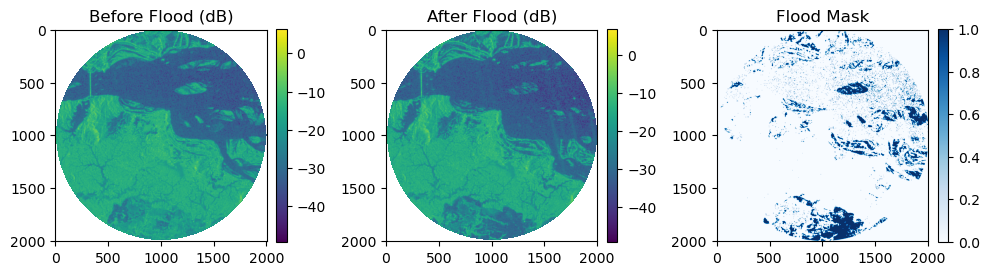

✅ Plot saved at: C:/Users/IshitaMonga/Desktop/Project new/output/New folder\flood_detection_results.png


In [70]:
import os

# Path where you want to save the plots
output_dir = r"C:/Users/IshitaMonga/Desktop/Project new/output/New folder"  # change to your path
os.makedirs(output_dir, exist_ok=True)

# -------------------- Visualization --------------------
plt.figure(figsize=(10, 8))

# Before Flood
plt.subplot(1, 3, 1)
plt.title("Before Flood (dB)")
plt.imshow(before_db, cmap='viridis')
plt.colorbar(fraction=0.046, pad=0.04, shrink=0.7)

# After Flood
plt.subplot(1, 3, 2)
plt.title("After Flood (dB)")
plt.imshow(after_db, cmap='viridis')
plt.colorbar(fraction=0.046, pad=0.04, shrink=0.7)

# Flood Mask
plt.subplot(1, 3, 3)
plt.title("Flood Mask")
plt.imshow(flood_mask_clean, cmap='Blues')
plt.colorbar(fraction=0.046, pad=0.04, shrink=0.7)

plt.tight_layout()

# Save the plots as PNG
plot_path = os.path.join(output_dir, "flood_detection_results.png")
plt.savefig(plot_path, dpi=300, bbox_inches='tight')
plt.show()

print(f"✅ Plot saved at: {plot_path}")

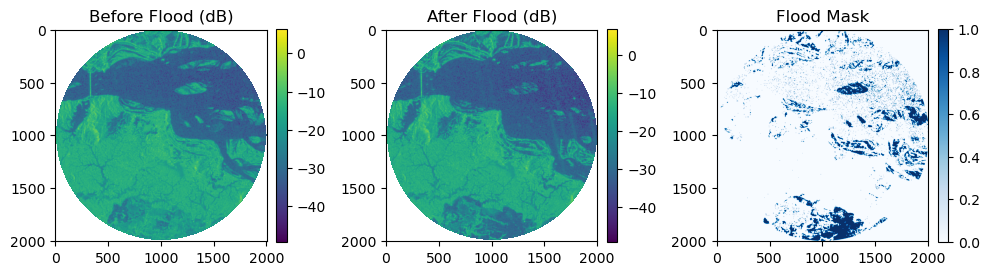

✅ Flood mask saved as flood_mask.tif
✅ Otsu threshold: -4.68 dB change


In [71]:
plt.figure(figsize=(10, 8))
plt.subplot(1, 3, 1)
plt.title("Before Flood (dB)")
plt.imshow(before_db, cmap='viridis')
plt.colorbar(fraction=0.046, pad=0.04, shrink=0.7)

plt.subplot(1, 3, 2)
plt.title("After Flood (dB)")
plt.imshow(after_db, cmap='viridis')
plt.colorbar(fraction=0.046, pad=0.04, shrink=0.7)

plt.subplot(1, 3, 3)
plt.title("Flood Mask")
#plt.imshow(flood_mask_clean, cmap='Blues')

plt.imshow(flood_mask_clean, cmap='Blues')  # colorful map
plt.colorbar(fraction=0.046, pad=0.04, shrink=0.7)

plt.tight_layout()
plt.show()

print(f"✅ Flood mask saved as flood_mask.tif")
print(f"✅ Otsu threshold: {otsu_thresh:.2f} dB change")

In [72]:
# Save the output plot
plt.savefig("flood_detection_results.png", dpi=300, bbox_inches='tight')

plt.show()

print("✅ Flood mask saved as flood_mask.tif")
print("✅ Plot saved as flood_detection_results.png")
print(f"✅ Otsu threshold: {otsu_thresh:.2f} dB change")

<Figure size 640x480 with 0 Axes>

✅ Flood mask saved as flood_mask.tif
✅ Plot saved as flood_detection_results.png
✅ Otsu threshold: -4.68 dB change
